Import libraries

In [64]:
import os 
import copy
import collections
import numpy as np 
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pathlib import Path
from pprint import pprint
from scipy.stats import pearsonr

import matplotlib.pyplot as plt 
from brokenaxes import brokenaxes

import torch

from utils import load_pickle, pickle_data

Settings

In [92]:
top_k = 1000
cache_folder = "./cache"
IF_cache_folder = os.path.join(cache_folder, "IF_results")
IF_plots_folder = os.path.join(IF_cache_folder, "IF_plots")
if not os.path.exists(IF_cache_folder): os.makedirs(IF_cache_folder)
if not os.path.exists(IF_plots_folder): os.makedirs(IF_plots_folder)

baseline_models_folder = "../FP_prediction/baseline_models/best_models"
mist_folder = "../FP_prediction/mist/best_models"

data_folder = Path("/data/rbg/users/klingmin/projects/MS_processing/data")
results_folder = []

for folder in [mist_folder, baseline_models_folder]:
    for dataset in os.listdir(folder):
        for checkpoint in os.listdir(os.path.join(folder, dataset)):
            if "sieved" in checkpoint: continue
            results_folder.append(os.path.join(folder, dataset, checkpoint))

diff_expt_conditions = ["diff_adduct", "diff_instrument", "diff_CE",
                        "diff_adduct_instrument", "diff_adduct_CE",
                        "diff_instrument_CE", "diff_adduct_instrument_CE"]

model_mapping = {"binned_": "B-MLP",
                 "MS_": "MS-T",
                 "formula_": "CF-T",
                 "MIST_": "MIST"}

dataset_mapping = {"C": "NPLIB1",
                   "MSG": "MassSpecGym",
                   "NIST2023": "NIST2023"}

folder_dataset_mapping = {"C": "canopus",
                   "MSG": "massspecgym",
                   "NIST2023": "nist2023"}

split_mapping = {"scaffold_vanilla": "Scaffold-split",
                 "inchikey_vanilla": "InChIKey-split",
                 "random": "Random-split",
                 "LS": "LS-split"}

helpful_color_code, harmful_color_code= "#BBAEA5", "#D9D5C8"


helpful_color_code_MS, harmful_color_code_MS = "#6B8F71", "#F4E285"



Helper Functions

`` We want to support results from LS ``

    1. We show how the percentage of helpful samples for identical molecules varies depending on whether they were obtained under identical or different experimental conditions.

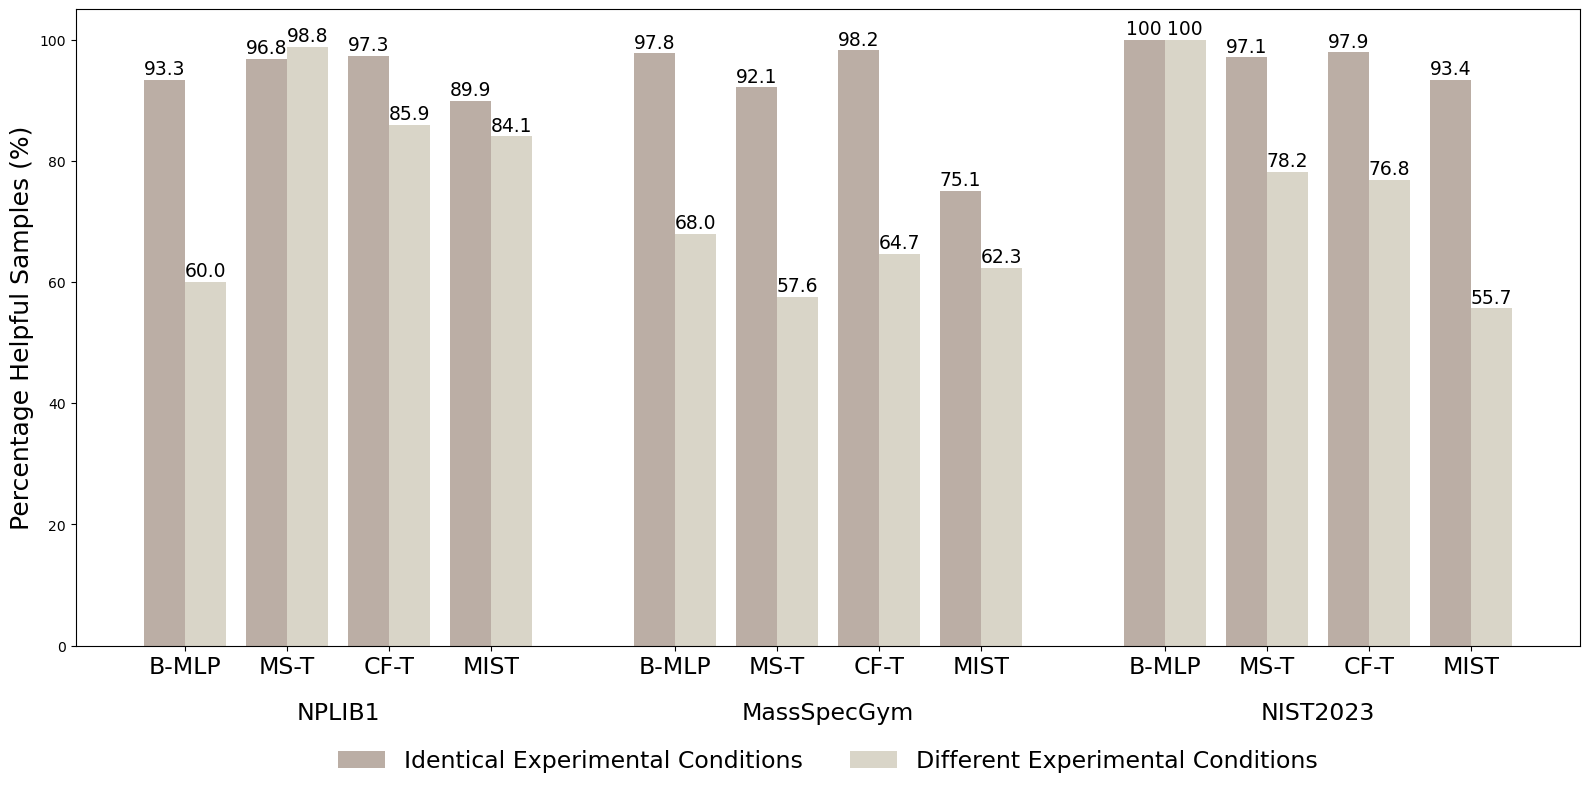

In [45]:
results_cache = [f for f in os.listdir(IF_cache_folder) if "random" in f]

datasets = ["C", "MSG", "NIST2023"]
models = ["binned_", "MS_", "formula_", "MIST_"] #"binned_", "MS_", "formula_", 

# Get the percentage positive and negative for identical molecules for each model and dataset 
helpful_same_percent, helpful_diff_percent = [], []

for dataset in datasets:

    for model in models: 

        results_path = [f for f in results_cache if dataset in f and model in f if "sieved" not in f]
        assert len(results_path) == 1
        results_path = os.path.join(IF_cache_folder, results_path[0], "identical_molecules_harmful_helpful.pkl")

        results = load_pickle(results_path)
        helpful_same, helpful_diff = results["same_mol_ident_expt"]["helpful"], results["same_mol_diff_expt"]["helpful"]

        helpful_same = round(helpful_same * 100, 3)
        helpful_diff = round(helpful_diff * 100, 3)

        helpful_same_percent.append(helpful_same)
        helpful_diff_percent.append(helpful_diff)

same_percent = np.array(helpful_same_percent).reshape(len(datasets), len(models))
diff_percent = np.array(helpful_diff_percent).reshape(len(datasets), len(models))

# Parameters
bar_width = 0.4
bar_spacing = 1.0
group_spacing = 0.8
n_models = len(models)

# Compute positions
x_positions = []
model_labels = []
dataset_boundaries = []

for d_idx, dataset in enumerate(datasets):
    group_start = d_idx * (n_models * bar_spacing + group_spacing)
    group_centers = []

    for m_idx, model in enumerate(models):
        center = group_start + m_idx * bar_spacing + (bar_width / 2)
        x_positions.append(center)
        model_labels.append(model_mapping[model])
        group_centers.append(center)

    dataset_boundaries.append(np.mean(group_centers))

# Flatten data
same_flat = [p for group in same_percent for p in group]
diff_flat = [n for group in diff_percent for n in group]

# Plot
fig, ax = plt.subplots(figsize=(16, 8))

x_positions = np.array(x_positions)
ax.bar(x_positions - bar_width/2, same_flat, bar_width, label='Identical Experimental Conditions', color = helpful_color_code)
ax.bar(x_positions + bar_width/2, diff_flat, bar_width, label='Different Experimental Conditions', color = harmful_color_code)

# # Plot dots and connecting lines
# for x_left, x_right, y1, y2 in zip(x_positions - bar_width/2, x_positions + bar_width/2, same_flat, diff_flat):
#     # Dots
#     ax.scatter(x_left, y1, color='black', s=25, zorder=5)
#     ax.scatter(x_right, y2, color='black', s=25, zorder=5)
#     # Line
#     ax.plot([x_left, x_right], [y1, y2], color='grey', linestyle='dotted', linewidth=1.5, zorder=4)

# Main x-axis: model labels
ax.set_xticks(x_positions)
ax.set_xticklabels(model_labels, fontsize = 17)
ax.set_ylabel('Percentage Helpful Samples (%)', fontsize = 18)
# ax.set_title('Percentage of Helpful and Harmful Influence Score for Identical Molecules, Different Experimental Conditions', fontsize=14)
ax.legend(
    fontsize=17,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.13),  # Adjust this to control exact position
    ncol=2,                       # Put items in a single row (or adjust as needed)
    frameon=False                 # Optional: remove legend box
)

# Secondary x-axis for dataset grouping
ax2 = ax.secondary_xaxis('bottom')
ax2.set_xticks(dataset_boundaries)

ax2.set_xticklabels([dataset_mapping[d] for d in datasets])
ax2.spines['bottom'].set_visible(False)
ax2.tick_params(axis='x', length=0, pad=40, labelsize=17)

# Add text labels
for xpos, height in zip(x_positions - bar_width/2, same_flat):
    if height == 100.0: 
        ax.text(xpos, height + 0.2, f'{height:.0f}', ha='center', va='bottom', fontsize=13.5)
    else:
        ax.text(xpos, height + 0.2, f'{height:.1f}', ha='center', va='bottom', fontsize=13.5)

for xpos, height in zip(x_positions + bar_width/2, diff_flat):
    if height == 100.0: 
        ax.text(xpos, height + 0.2, f'{height:.0f}', ha='center', va='bottom', fontsize=13.5)
    else:
        ax.text(xpos, height + 0.2, f'{height:.1f}', ha='center', va='bottom', fontsize=13.5)

plt.tight_layout()
plt.savefig(os.path.join(IF_plots_folder, "IF_identical_mol_helpful_harmful.png"), bbox_inches='tight')

plt.show()

`` Task 1: We want to show that MS similarity of identical molecules directly determines the harmfulness and helpfulness of a training sample``

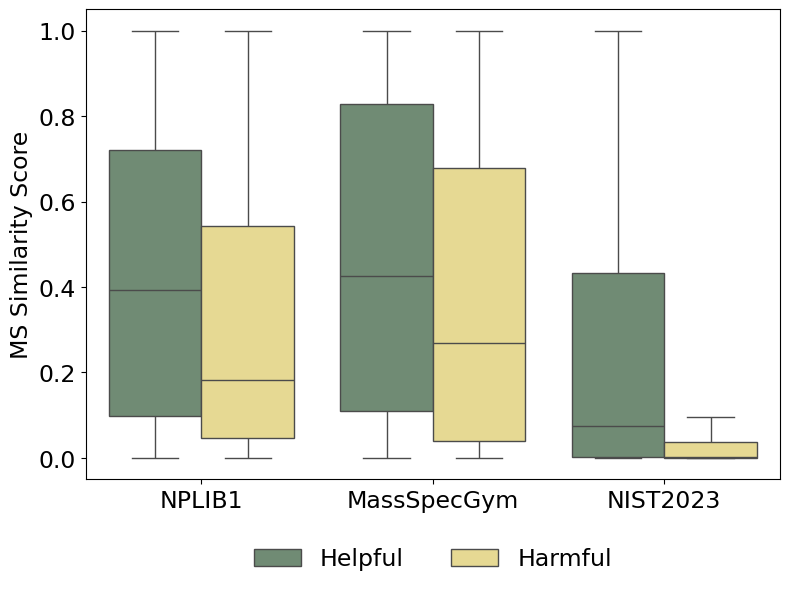

In [94]:
results_cache = [f for f in os.listdir(IF_cache_folder) if "random" in f]

datasets = ["C", "MSG", "NIST2023"]
models = ["binned_", "MS_", "formula_", "MIST_"]

all_scores = []  # list of dicts to build DataFrame

for dataset in datasets:
    for model in models:
        results_path = [f for f in results_cache if dataset in f and model in f and "sieved" not in f]
        assert len(results_path) == 1
        results_path = os.path.join(IF_cache_folder, results_path[0], "identical_molecules_MS_sim_harmful_helpful.pkl")
        results = load_pickle(results_path)

        results_helpful = results["helpful"]["diff_expt"]
        results_harmful = results["harmful"]["diff_expt"]

        if dataset == "C":
            threshold_helpful, threshold_harmful = 5.5, 0.1
        elif dataset == "MSG":
            threshold_helpful, threshold_harmful = 5.0, 1.0
        elif dataset == "nist2023":
            threshold_helpful, threshold_harmful = 5.0, 0.13

        # Add helpful samples
        for score, sim in results_helpful:
            if abs(score) >= threshold_helpful:
                all_scores.append({
                    "Type": "Helpful",
                    "Similarity": sim,
                    "Model": model_mapping[model],
                    "Dataset": dataset_mapping[dataset]
                })

        # Add harmful samples
        for score, sim in results_harmful:
            if abs(score) >= threshold_harmful:
                all_scores.append({
                    "Type": "Harmful",
                    "Similarity": sim,
                    "Model": model_mapping[model],
                    "Dataset": dataset_mapping[dataset]
                })

# Convert to DataFrame
df = pd.DataFrame(all_scores)

# Plot vertical box plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="Dataset", y="Similarity", hue="Type",
            palette={"Helpful": helpful_color_code_MS, "Harmful": harmful_color_code_MS}, fliersize=0)

plt.xlabel("", fontsize=17)
plt.ylabel("MS Similarity Score", fontsize=17)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

plt.legend(
    fontsize=17,
    loc="upper center",
    frameon = False,
    bbox_to_anchor=(0.5, -0.1),  # center it below the plot
    ncol=2  # optional: put legend entries in a row
)

plt.ylim(-0.05, 1.05)
plt.tight_layout()
plt.savefig(os.path.join(IF_plots_folder, "MS_sim_diff_expt_helpful_harmful.png"), bbox_inches='tight')
plt.show()